# DCGAN on MNIST (aligned with VAE_MNIST)

This notebook trains a simple DCGAN on MNIST with setup aligned to `VAE_MNIST.ipynb` so you can compare architectures fairly:
- Same device selection
- Same data normalization and batch size
- Same checkpoint cadence and sample saving cadence
- Latent_dim=64 to match VAE

In [1]:
# Imports and device
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device selection aligned with VAE_MNIST
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type.upper()}")

torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)

Using device: MPS


In [3]:
# Data: MNIST — same normalization/batch as VAE_MNIST
batch_size = 128
num_workers = 2

data_root = os.path.join(os.getcwd(), '../../data')
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

train_dataset = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=(device.type!='cpu'))
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device.type!='cpu'))

# Fixed noise for monitoring (latent_dim=64)
latent_dim = 64
fixed_noise = torch.randn(64, latent_dim, device=device)

len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
# DCGAN models for MNIST (1x28x28)
# Generator mirrors VAE_MNIST decoder depth, Discriminator mirrors VAE_MNIST encoder depth

class Generator(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64*7*7)  # 64x7x7
        self.net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 -> 28x28
            nn.Tanh(),
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 7, 7)
        x = self.net(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 14 -> 7
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Linear(64*7*7, 1)
    def forward(self, x):
        f = self.features(x)
        f = f.view(x.size(0), -1)
        logit = self.classifier(f)
        return logit.squeeze(1)

G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
print("Generator params:", sum(p.numel() for p in G.parameters())//1000, "K")
print("Discriminator params:", sum(p.numel() for p in D.parameters())//1000, "K")

Generator params: 237 K
Discriminator params: 36 K


In [5]:
# Training setup and loop (aligned cadence with VAE_MNIST)
criterion = nn.BCEWithLogitsLoss()
# Use same optimizer lr as VAE_MNIST for fairness
optimizer_G = optim.Adam(G.parameters(), lr=2e-3)
optimizer_D = optim.Adam(D.parameters(), lr=1e-3)

max_epochs = 30
ckpt_dir = './checkpoints_gan_mnist'
os.makedirs(ckpt_dir, exist_ok=True)
sample_dir = './gan_mnist_samples'
os.makedirs(sample_dir, exist_ok=True)

start_epoch = 0
latest_ckpt = os.path.join(ckpt_dir, 'gan_mnist_latest.pth')
if os.path.exists(latest_ckpt):
    ckpt = torch.load(latest_ckpt, map_location=device)
    G.load_state_dict(ckpt['G'])
    D.load_state_dict(ckpt['D'])
    optimizer_G.load_state_dict(ckpt['optG'])
    optimizer_D.load_state_dict(ckpt['optD'])
    start_epoch = ckpt['epoch']
    fixed_noise = ckpt.get('fixed_noise', fixed_noise)
    print(f"Resuming GAN MNIST training from epoch {start_epoch}")

# Utility to save samples
def save_samples(epoch):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        fake = fake * 0.5 + 0.5
        grid = vutils.make_grid(fake, nrow=8, padding=2)
        plt.figure(figsize=(8,8))
        plt.axis('off')
        plt.title(f'GAN MNIST Samples - Epoch {epoch}')
        plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
        out_path = os.path.join(sample_dir, f'samples_epoch_{epoch}.png')
        plt.savefig(out_path)
        plt.close()
    G.train()

real_label = 1.
fake_label = 0.

for epoch in range(start_epoch, max_epochs):
    G.train(); D.train()
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0

    for real, _ in train_loader:
        real = real.to(device)
        bsz = real.size(0)

        # Train D
        optimizer_D.zero_grad()
        logits_real = D(real)
        labels_real = torch.full((bsz,), real_label, device=device)
        loss_real = criterion(logits_real, labels_real)

        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z).detach()
        logits_fake = D(fake)
        labels_fake = torch.full((bsz,), fake_label, device=device)
        loss_fake = criterion(logits_fake, labels_fake)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train G
        optimizer_G.zero_grad()
        z = torch.randn(bsz, latent_dim, device=device)
        fake = G(z)
        logits_fake = D(fake)
        labels_gen = torch.full((bsz,), real_label, device=device)
        loss_G = criterion(logits_fake, labels_gen)
        loss_G.backward()
        optimizer_G.step()

        d_loss_epoch += loss_D.item() * bsz
        g_loss_epoch += loss_G.item() * bsz

    n = len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{max_epochs} | D: {d_loss_epoch/n:.4f} | G: {g_loss_epoch/n:.4f}")

    # Checkpoints every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'G': G.state_dict(),
            'D': D.state_dict(),
            'optG': optimizer_G.state_dict(),
            'optD': optimizer_D.state_dict(),
            'fixed_noise': fixed_noise
        }, os.path.join(ckpt_dir, f'gan_mnist_checkpoint_epoch_{epoch+1}.pth'))
        torch.save({
            'epoch': epoch + 1,
            'G': G.state_dict(),
            'D': D.state_dict(),
            'optG': optimizer_G.state_dict(),
            'optD': optimizer_D.state_dict(),
            'fixed_noise': fixed_noise
        }, latest_ckpt)

    # Samples every 20 epochs
    if (epoch + 1) % 5 == 0:
        save_samples(epoch + 1)

print("GAN MNIST Training complete!")

Resuming GAN MNIST training from epoch 30
GAN MNIST Training complete!


Generator output shape: torch.Size([4, 1, 28, 28])


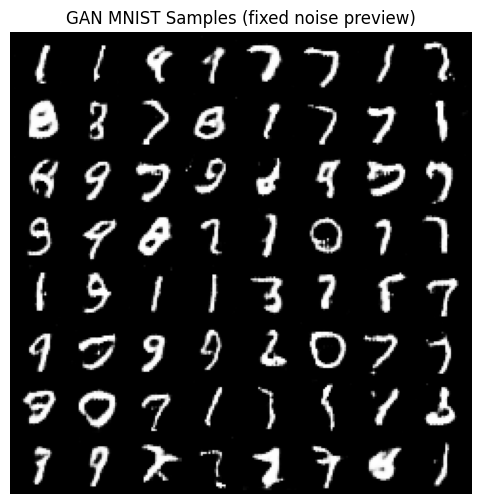

Found 6 saved GAN MNIST sample grids


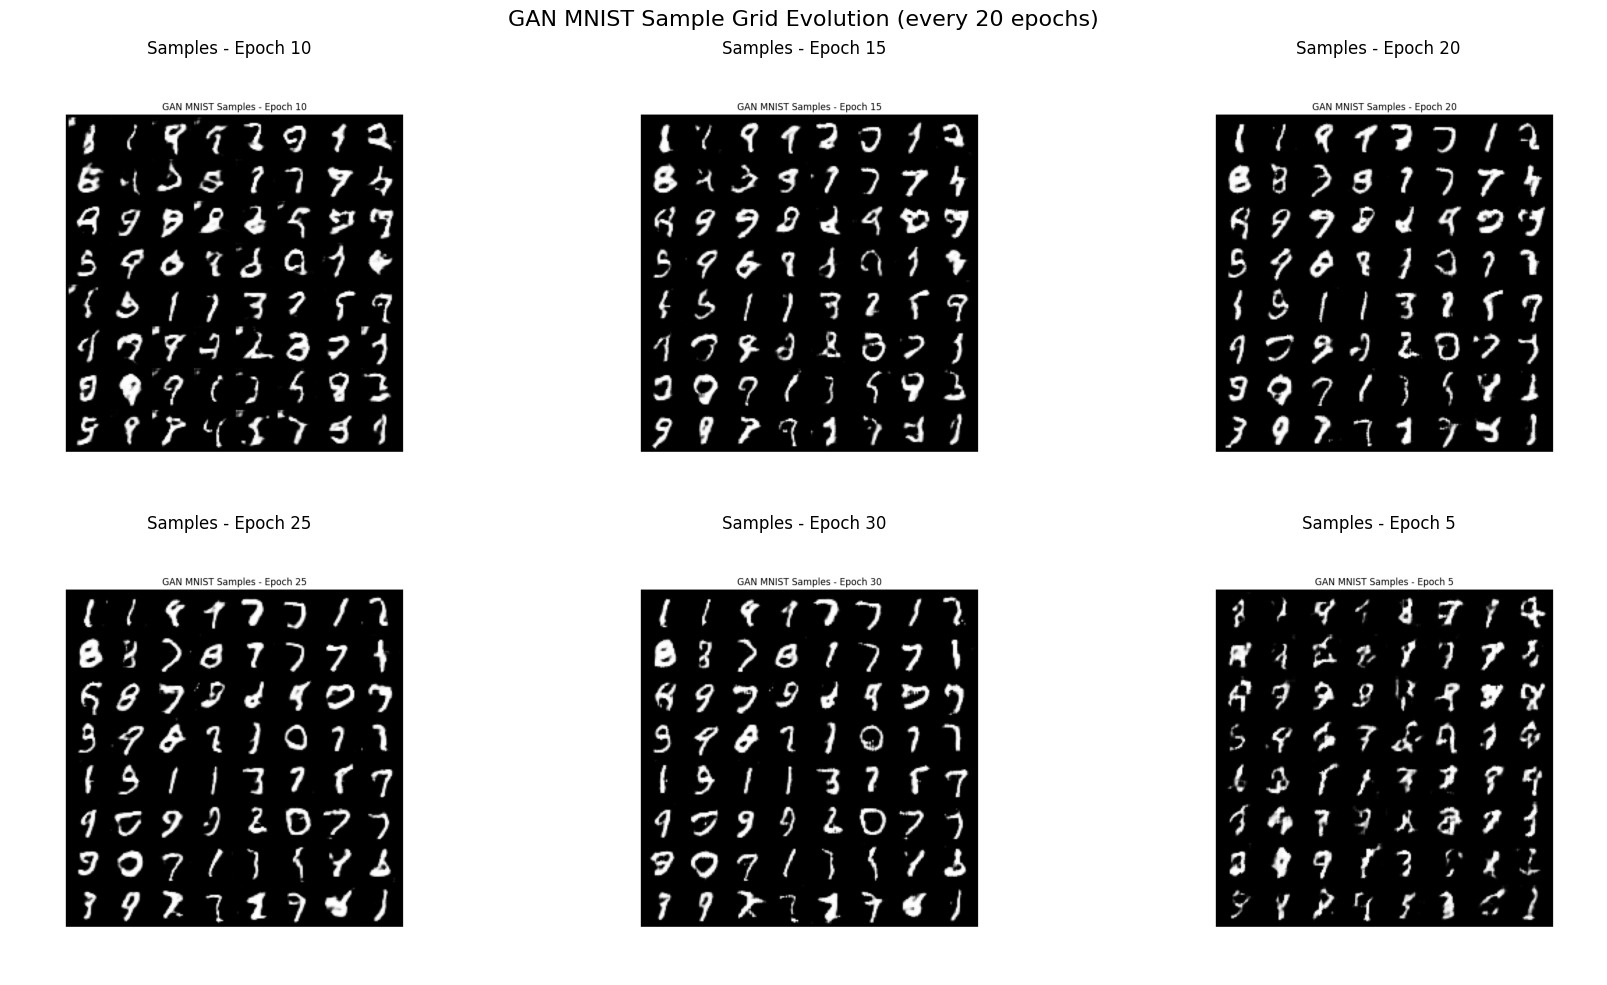

In [6]:
# Sanity checks and visualization
G.eval()
with torch.no_grad():
    z = torch.randn(4, latent_dim, device=device)
    out = G(z)
    print('Generator output shape:', out.shape)
G.train()

# Preview grid from fixed noise
G.eval()
with torch.no_grad():
    preview = G(fixed_noise).detach().cpu()*0.5 + 0.5
    grid = vutils.make_grid(preview, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('GAN MNIST Samples (fixed noise preview)')
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()

# Display saved sample grids
import glob
from PIL import Image
sample_dir = './gan_mnist_samples'
sample_files = sorted(glob.glob(os.path.join(sample_dir, 'samples_epoch_*.png')))
if sample_files:
    print(f'Found {len(sample_files)} saved GAN MNIST sample grids')
    n_cols = min(3, len(sample_files))
    n_rows = (len(sample_files) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    # Normalize axes to 2D array for any (rows, cols) combination
    axes = np.atleast_2d(axes)
    for i, f in enumerate(sample_files):
        r, c = i // n_cols, i % n_cols
        img = Image.open(f)
        axes[r, c].imshow(img)
        ep = f.split('_')[-1].split('.')[0]
        axes[r, c].set_title(f'Samples - Epoch {ep}')
        axes[r, c].axis('off')
    for i in range(len(sample_files), n_rows*n_cols):
        r, c = i // n_cols, i % n_cols
        axes[r, c].axis('off')
    plt.suptitle('GAN MNIST Sample Grid Evolution (every 20 epochs)', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No saved GAN MNIST samples yet. Train the GAN or wait for the first 20-epoch save.')

Loading GAN MNIST checkpoint: ./checkpoints_gan_mnist/gan_mnist_checkpoint_epoch_30.pth


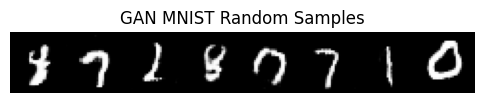

In [7]:
# Load latest GAN MNIST checkpoint and sample
import glob
latest = None
ckpts = glob.glob('./checkpoints_gan_mnist/gan_mnist_checkpoint_epoch_*.pth')
if ckpts:
    latest = max(ckpts, key=lambda p: int(p.split('_')[-1].split('.')[0]))
elif os.path.exists('./checkpoints_gan_mnist/gan_mnist_latest.pth'):
    latest = './checkpoints_gan_mnist/gan_mnist_latest.pth'

if latest:
    print(f"Loading GAN MNIST checkpoint: {latest}")
    state = torch.load(latest, map_location=device)
    G.load_state_dict(state['G'])
    D.load_state_dict(state['D'])
else:
    print('No GAN MNIST checkpoint found, using current weights.')

G.eval()
with torch.no_grad():
    # Show only one row of 8 samples from random noise (not fixed)
    z = torch.randn(8, latent_dim, device=device)
    preview = G(z).detach().cpu()*0.5 + 0.5
    grid = vutils.make_grid(preview, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.title('GAN MNIST Random Samples')
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.show()

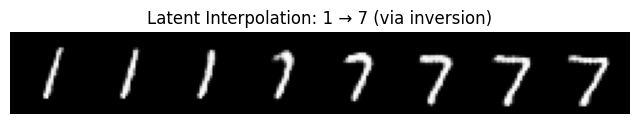

In [8]:
# Interpolate from digit 1 to digit 7 via latent inversion
# We find latent codes z1 and z7 whose generated images match real MNIST samples of labels 1 and 7,
# then linearly interpolate between them.

# Helper: fetch one sample by label from the dataset (already normalized to [-1,1])
def get_one_sample_by_label(dataset, label):
    for img, lbl in dataset:
        if int(lbl) == int(label):
            return img.unsqueeze(0).to(device)  # shape: 1x1x28x28
    raise ValueError(f"Label {label} not found in dataset")

# Latent inversion: optimize z so that G(z) ~= target image
def invert_to_latent(target_img, steps=300, lr=0.1, lambda_prior=1e-3):
    # target_img expected shape: 1x1x28x28 in [-1,1]
    z = torch.randn(1, latent_dim, device=device, requires_grad=True)
    opt = torch.optim.Adam([z], lr=lr)

    # Freeze G params during inversion
    was_training = G.training
    G.eval()
    for p in G.parameters():
        p.requires_grad_(False)

    best_z = z.detach().clone()
    best_loss = float('inf')
    for i in range(steps):
        opt.zero_grad()
        recon = G(z)
        loss_recon = torch.mean((recon - target_img) ** 2)
        loss_prior = torch.mean(z ** 2)
        loss = loss_recon + lambda_prior * loss_prior
        loss.backward()
        opt.step()
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_z = z.detach().clone()

    # Unfreeze G params back
    for p in G.parameters():
        p.requires_grad_(True)
    if was_training:
        G.train()

    return best_z

# Pick one real '1' and one real '7' from the test set
target_1 = get_one_sample_by_label(test_dataset, 1)
target_7 = get_one_sample_by_label(test_dataset, 7)

# Invert to latent space
z1 = invert_to_latent(target_1, steps=300, lr=0.1)
z7 = invert_to_latent(target_7, steps=300, lr=0.1)

# Interpolate between z1 and z7 (8 steps => 1x8 row)
alphas = torch.linspace(0, 1, steps=8, device=device).view(-1, 1)
zs = (1 - alphas) * z1 + alphas * z7

with torch.no_grad():
    imgs = G(zs).detach().cpu() * 0.5 + 0.5  # [0,1]
    grid = vutils.make_grid(imgs, nrow=8, padding=2)

plt.figure(figsize=(8, 3))
plt.axis('off')
plt.title('Latent Interpolation: 1 → 7 (via inversion)')
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
plt.show()

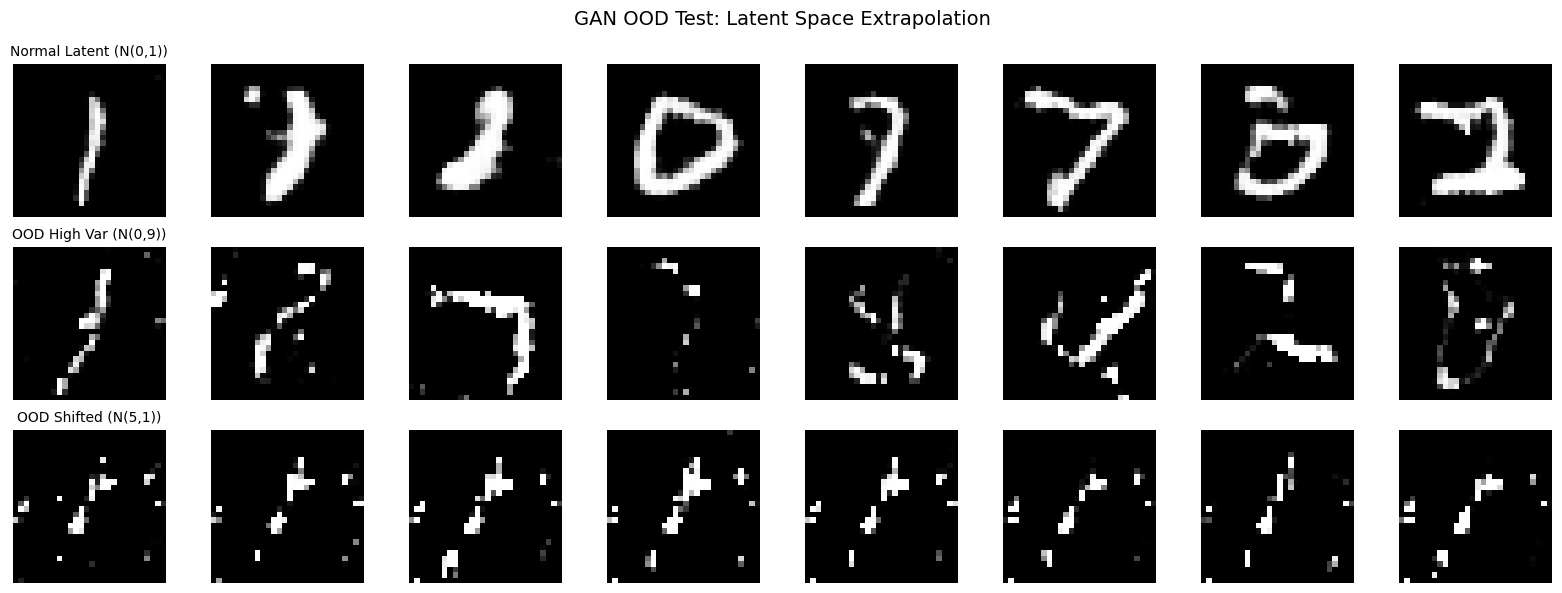

Average latent norm (Normal): 7.87782096862793
Average latent norm (OOD High Var): 23.54134178161621
Average latent norm (OOD Shifted): 41.04157257080078


In [9]:
# GAN OOD Test: Extrapolation in Latent Space
# Sample latent vectors far from the training distribution (e.g., high variance or large norms)
# to test OOD robustness by generating images from "unseen" latent regions.

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Ensure G is loaded and in eval mode
G.eval()

# Normal latent samples (ID-like)
z_normal = torch.randn(8, latent_dim, device=device)
with torch.no_grad():
    imgs_normal = G(z_normal).detach().cpu() * 0.5 + 0.5

# OOD latent samples: high variance (e.g., N(0, 10))
z_ood_high_var = torch.randn(8, latent_dim, device=device) * 3.0  # std=3 instead of 1
with torch.no_grad():
    imgs_ood_high_var = G(z_ood_high_var).detach().cpu() * 0.5 + 0.5

# OOD latent samples: shifted mean (e.g., N(5, 1))
z_ood_shifted = torch.randn(8, latent_dim, device=device) + 5.0
with torch.no_grad():
    imgs_ood_shifted = G(z_ood_shifted).detach().cpu() * 0.5 + 0.5

# Visualize: Normal vs OOD (high var) vs OOD (shifted)
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for i in range(8):
    # Normal
    axes[0, i].imshow(imgs_normal[i].squeeze(0).numpy(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Normal Latent (N(0,1))', fontsize=10)
    
    # OOD High Var
    axes[1, i].imshow(imgs_ood_high_var[i].squeeze(0).numpy(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('OOD High Var (N(0,9))', fontsize=10)
    
    # OOD Shifted
    axes[2, i].imshow(imgs_ood_shifted[i].squeeze(0).numpy(), cmap='gray')
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_title('OOD Shifted (N(5,1))', fontsize=10)

plt.suptitle('GAN OOD Test: Latent Space Extrapolation', fontsize=14)
plt.tight_layout()
plt.show()

# Optional: Print latent norms for comparison
print("Average latent norm (Normal):", torch.norm(z_normal, dim=1).mean().item())
print("Average latent norm (OOD High Var):", torch.norm(z_ood_high_var, dim=1).mean().item())
print("Average latent norm (OOD Shifted):", torch.norm(z_ood_shifted, dim=1).mean().item())

In [12]:
# Latent interpolation rows (GAN MNIST) — saves multiple rows like CelebA
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils as vutils

# Output directory for interpolation rows
interp_dir = './gan_mnist_interpolations'
os.makedirs(interp_dir, exist_ok=True)

# Generate 'pairs' rows; each row interpolates between two random latent codes
def interpolate_pairs(steps=8, pairs=4, filename_prefix='interp'):
    G.eval()
    rows = []
    with torch.no_grad():
        for p in range(pairs):
            z0 = torch.randn(1, latent_dim, device=device)
            z1 = torch.randn(1, latent_dim, device=device)
            alphas = torch.linspace(0, 1, steps, device=device)
            z = (1 - alphas).unsqueeze(1) * z0 + alphas.unsqueeze(1) * z1
            imgs = G(z).detach().cpu() * 0.5 + 0.5  # [0,1] grayscale
            grid = vutils.make_grid(imgs, nrow=steps, padding=2)
            out_path = os.path.join(interp_dir, f'{filename_prefix}_{p+1}.png')
            plt.imsave(out_path, np.transpose(grid.numpy(), (1, 2, 0)), cmap='gray')
            rows.append(grid)
    print(f'Saved {pairs} interpolation rows to', interp_dir)

# Run a small interpolation batch
interpolate_pairs(steps=9, pairs=3)

Saved 3 interpolation rows to ./gan_mnist_interpolations
